<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
# Descargar el diccionario
nltk.download("punkt")
nltk.download("wordnet")

import multiprocessing
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Datos
Utilizaremos como dataset discursos políticos de la ex presidenta Cristina Cristina Fernández de Kirchner. La idea es no entrar en ideologías ni discusiones políticas sino ver que palabras relaciona "más" el modelo a palabras claves y también como esto se modifica en los discursos de dos años (2008 y 2017).

La selección de la persona fue únicamente por su capacidad como oradora y por la disponibilidad de los datos.

In [ ]:
#Carga de datos
with open('/content/texto2008.txt', 'r') as file:
  raw_discursos_2008 = file.read()

with open('/content/texto2017.txt', 'r') as file:
  raw_discursos_2017 = file.read()


In [ ]:
def clean_text(raw_text):
  text=list(filter(bool, raw_text.split('.')))
  return text

In [ ]:
discursos_2008 = clean_text(raw_discursos_2008)
print("Cantidad de documentos 2008:", len(discursos_2008))
print(discursos_2008[0])

Cantidad de documentos 2008: 406
Muy buenas tardes a todos y a todas; señores gobernadores, señores legisladores; señores dirigentes sindicales; señor Secretario General de la CTA; señor Secretario General de la CGT: en principio pedir disculpas a todos ustedes por estar aquí muy apretados en esta carpa, pero fue una decisión de esta presidenta que este acto tuviera lugar aquí, en el ANSES, no es una casualidad, no es un capricho, es simplemente la decisión de también a través de lo simbólico saber que hoy estamos decidiendo sobre el patrimonio de los jubilados de nuestro país, y el patrimonio de los jubilados de nuestro país no tenía por qué estar en el Salón Blanco de la Casa de Gobierno, tenía que estar aquí en el ANSES, en su natural lugar


In [ ]:
discursos_2017 = clean_text(raw_discursos_2017)
print("Cantidad de documentos 2008:", len(discursos_2017))
print(discursos_2017[0])

Cantidad de documentos 2008: 616
Muchas gracias a todos, a todas trabajadores y trabajadoras de prensa


### Discursos 2008

#### 1 - Preprocesamiento

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for row in discursos_2008:
    sentence_tokens.append(text_to_word_sequence(row))

In [ ]:
# Demos un vistazo
sentence_tokens[0][0:5]

['muy', 'buenas', 'tardes', 'a', 'todos']

#### 2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 406


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 515


#### 3 - Entrenar el modelo generador

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 156263.609375
Loss after epoch 1: 88927.875
Loss after epoch 2: 88877.140625
Loss after epoch 3: 88741.71875
Loss after epoch 4: 88302.59375
Loss after epoch 5: 88735.125
Loss after epoch 6: 89245.875
Loss after epoch 7: 90873.9375
Loss after epoch 8: 91188.1875
Loss after epoch 9: 90814.375
Loss after epoch 10: 88131.5625
Loss after epoch 11: 79804.5
Loss after epoch 12: 79523.125
Loss after epoch 13: 78616.625
Loss after epoch 14: 78926.75
Loss after epoch 15: 77958.0
Loss after epoch 16: 77403.375
Loss after epoch 17: 77769.625
Loss after epoch 18: 77877.875
Loss after epoch 19: 77592.625


(157045, 350800)

#### 4 - Ensayar

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["argentina"], topn=10)

[('la', 0.973285973072052),
 ('república', 0.9716184139251709),
 ('hermana', 0.9457426071166992),
 ('presidente', 0.937554121017456),
 ('en', 0.9269363880157471),
 ('bolivia', 0.925162136554718),
 ('nuestra', 0.9159132242202759),
 ('américa', 0.9137928485870361),
 ('mi', 0.9125527143478394),
 ('donde', 0.9124279022216797)]

Notamos gran presencia de las palabra república lo cual era esperable.

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["argentino"], topn=10)

[('tal', -0.6362572312355042),
 ('vez', -0.6623671054840088),
 ('muchas', -0.6909328699111938),
 ('cada', -0.7149629592895508),
 ('gracias', -0.720418393611908),
 ('sus', -0.7263839244842529),
 ('uno', -0.7461254000663757),
 ('materia', -0.7561880946159363),
 ('veces', -0.7900851964950562),
 ('los', -0.805310845375061)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["política"], topn=10)

[('económica', 0.9939993023872375),
 ('viene', 0.9909510612487793),
 ('distribución', 0.9908921122550964),
 ('definitiva', 0.9901146292686462),
 ('mercosur', 0.9899274110794067),
 ('memoria', 0.9898775219917297),
 ('anses', 0.9896991848945618),
 ('inequidad', 0.9894982576370239),
 ('pensamos', 0.9894669055938721),
 ('internacional', 0.9893531203269958)]

En este apartado hay conexiones interesantes como económica, distribución e inequidad.

#### 5 - Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=100
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab


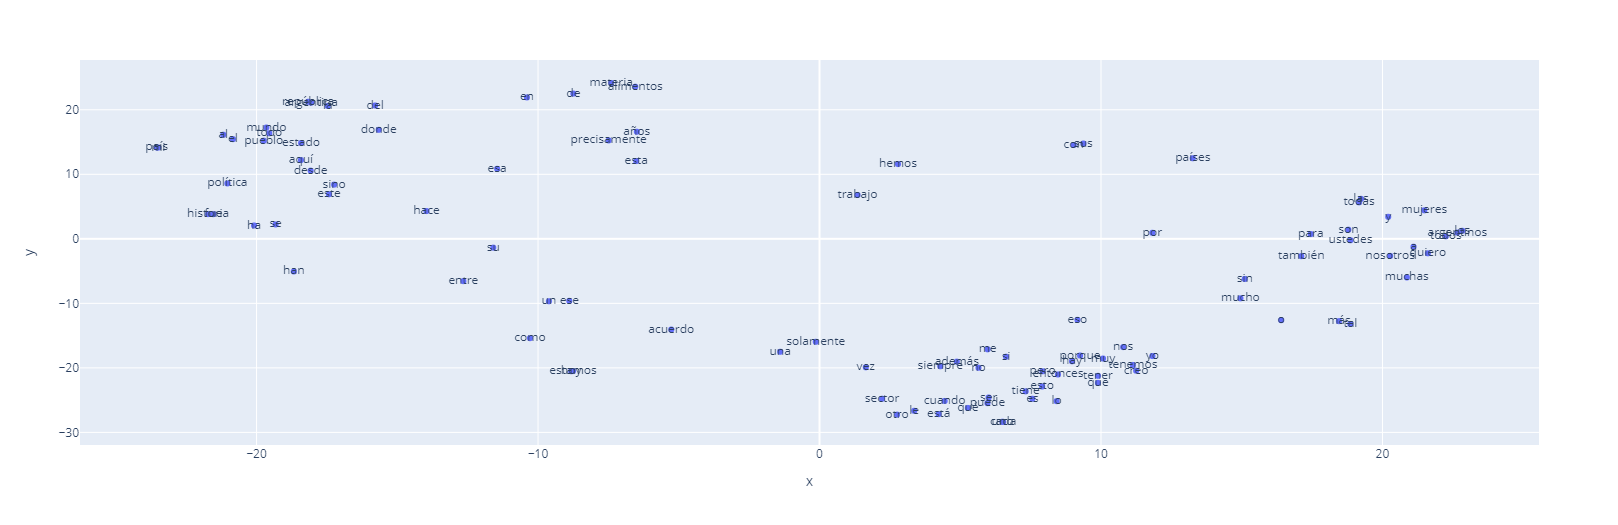

In [ ]:
from IPython.display import Image
Image(filename='/content/2008.png', width=2000)

En el gráfico se pueden observar algunas cosas interesantes. Por ejemplo la conexión casi perfecta entre "la", "república" y "Argentina".

También se observa conexión fuerte entre las palabras "estado" y "pueblo".

Sobre el lateral derecho, hay conexiones entre palabras como "quiero", "argentinos" y "mujeres". Se puede suponer que esta conexión proviene del lado del afecto.

Finalmente se observa gran cantidad de conexiones entre preposiciones y verbos en sus diferentes conjugaciones.

### Discursos 2017

#### 1 - Preprocesamiento

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for row in discursos_2017:
    sentence_tokens.append(text_to_word_sequence(row))

In [ ]:
# Demos un vistazo
sentence_tokens[0][0:4]

['muchas', 'gracias', 'a', 'todos']

#### 2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 616


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 544


#### 3 - Entrenar el modelo generador

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 159079.203125
Loss after epoch 1: 90907.765625
Loss after epoch 2: 91398.21875
Loss after epoch 3: 89814.0
Loss after epoch 4: 89163.78125
Loss after epoch 5: 89824.90625
Loss after epoch 6: 91023.875
Loss after epoch 7: 92244.0
Loss after epoch 8: 92271.0
Loss after epoch 9: 90677.8125
Loss after epoch 10: 89972.4375
Loss after epoch 11: 82066.25
Loss after epoch 12: 80760.125
Loss after epoch 13: 80259.875
Loss after epoch 14: 80142.125
Loss after epoch 15: 80413.0
Loss after epoch 16: 80480.125
Loss after epoch 17: 80590.5
Loss after epoch 18: 80649.125
Loss after epoch 19: 81008.0


(165263, 381360)

#### 4 - Ensayar

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["argentina"], topn=10)

[('república', 0.9704345464706421),
 ('en', 0.965149998664856),
 ('la', 0.9591444730758667),
 ('como', 0.9304224252700806),
 ('sociedad', 0.9180277585983276),
 ('democracia', 0.9154567718505859),
 ('de', 0.9148116707801819),
 ('fue', 0.913988471031189),
 ('toda', 0.913358747959137),
 ('provincia', 0.9124040603637695)]

Al caso anterior, se agregan palabras como sociedad y democracia.

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["argentino"], topn=10)

[('img', -0.03536156937479973),
 ('ni', -0.7716951370239258),
 ('todos', -0.828914999961853),
 ('argentina', -0.8601272106170654),
 ('no', -0.8647822141647339),
 ('creo', -0.8761969208717346),
 ('a', -0.8822106122970581),
 ('república', -0.8828254342079163),
 ('los', -0.8829725980758667),
 ('nada', -0.8855574727058411)]

Este caso es curioso porque le asigna relación opuesta a argentino y argentina. Habría que analizar con mayor detalle a que se debe.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["política"], topn=10)

[('unidas', 0.9994730949401855),
 ('información', 0.9994136691093445),
 ('hicieron', 0.999349057674408),
 ('libertad', 0.9993384480476379),
 ('izquierda', 0.9993221759796143),
 ('maia', 0.9992518424987793),
 ('naciones', 0.9992427825927734),
 ('innovación', 0.999235212802887),
 ('25', 0.9992103576660156),
 ('derechas', 0.9991960525512695)]

En este caso, la palabra política se relaciona mas con libertad y con corrientes de pensamientos dentro de la política.

#### 5 - Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=100
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab


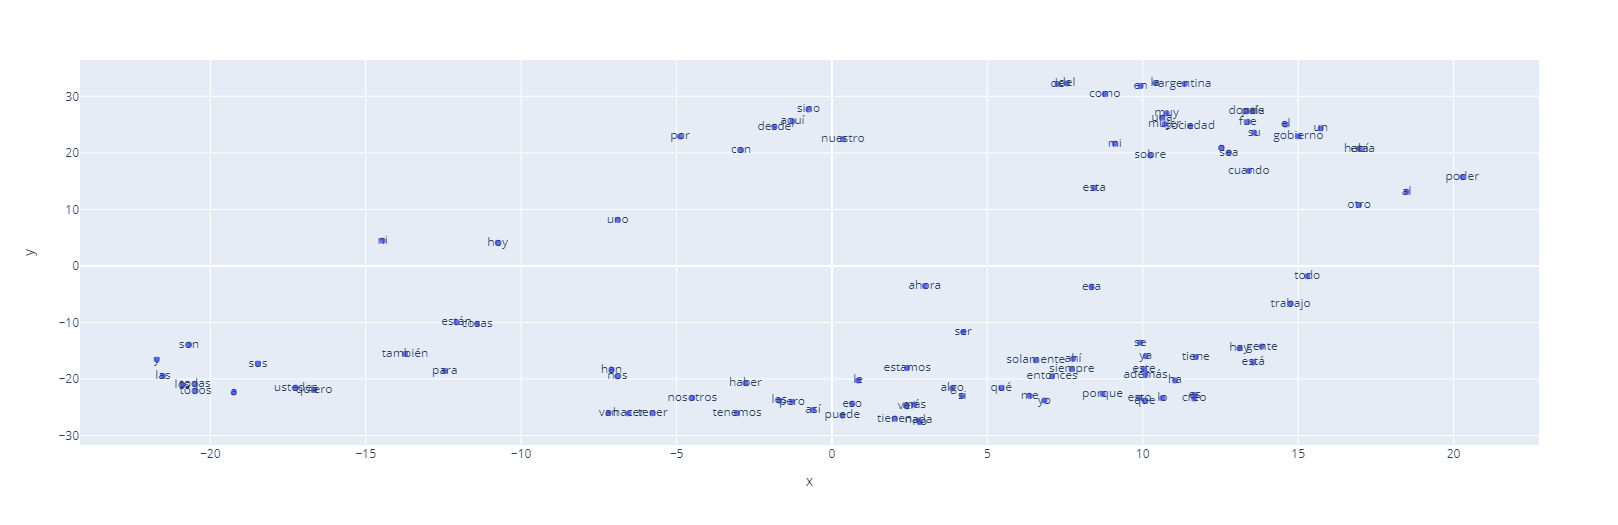

In [ ]:
Image(filename='/content/2017.png', width=2000)

En el gráfico se puede observar una cercanía marcada de las palabras "todos" y "todas". 

Contrario al anterior, en este caso "quiero" se relaciona con "todos" y "todas"; y "mujer" se relaciona más con "sociedad".

Finalmente, se mantienen las conexiones abundantes entre preposiciones y verbos.